# Mapping the seasonal changes to the open water extent of Lake Chad using Sentinel-1 and WOfS data

* **Products used:** 
[s1_rtc](https://explorer.digitalearth.africa/products/s1_rtc),
[wofs_ls](https://explorer.digitalearth.africa/wofs_ls), 
[rainfall_chirps_monthly](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly)

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.

A couple of very instructive papers on Lake Chad

- [The Lake Chad hydrology under current climate change](https://www.nature.com/articles/s41598-020-62417-w)
- [Recent Surface Water Extent of Lake Chad from Multispectral Sensors and GRACE](https://www.mdpi.com/1424-8220/18/7/2082)

## Description

The notebook demonstrates how to:

1. Load Sentinel-1 and Wofs satellite data over the water body of interest
2. Calculate the water index SWI
3. Resample the time-series of WOfS and SWI to monthly maximums
4. Generate animations of the water extent time-series
5. Calculate and plot a time series of seasonal water extent (in square kilometres)
6. Find the minimum and maximum water extents in the time-series and plot them.
7. Compare two nominated time-periods, and plot where the water-body extent has changed.

***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr
import geopandas as gpd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.storage import masking
from datacube.utils import geometry
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard, wofs_fuser
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize

from datacube.utils.aws import configure_s3_access

configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.8/site-packages/datacube/storage/masking.py:7: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  warnings.warn("datacube.storage.masking has moved to datacube.utils.masking",


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [2]:
dc = datacube.Datacube(app='water_extent')

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [3]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36293 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:43517 Dashboard: /user/victoria/proxy/36293/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `vector_file`: The path to the shapefile or geojson that will define the analysis area of the study.
* `time_range` : The date range to analyse (e.g. `('2017', '2019')`.
* `resolution` : The pixel resolution of the satellite data. `(-30,30)` for Landsat or `(-10,10)` for Sentinel-2.
* `dask_chunks`: Chunk sizes to use for dask.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers Lake Chad. 

**Current default is Lake Sulunga. Tanzania.**

In [4]:
# Define the area of interest.
# vector_file = 'data/lake_chad_extent.geojson'
# gdf = gpd.read_file(vector_file)

# bbox=list(gdf.total_bounds)
# lon_range = (bbox[0], bbox[2])
# lat_range = (bbox[1], bbox[3])

# Define the area of interest.
lat = -5.9460  # -6.0873
lon = 35.5188  # 35.1817

lat_buffer = 0.03
lon_buffer = 0.03

# Combine central lat,lon with buffer to get area of interest.
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the start year and end year.
time_range = ("2020-01", "2020-12")

# Define the resolution to load the data.
resolution = (-30, 30)

# Define the dask chunks to be used.
dask_chunks = {"time": 1, "x": 1500, "y": 1500}

## View the area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [5]:
display_map(lon_range, lat_range)

## Load the Senitnel-1 and  WOfS Feature Layers (WOFLs) data

The code below will create a query dictionary for our region of interest, and then load the Sentinel-1 and  WOfS Feature Layers (WOFLs) data.
For more information on loading data, see the [Loading data notebook](../Beginners_guide/03_Loading_data.ipynb).

In [6]:
# Create a query object.
query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "resolution": resolution,
    "output_crs": "EPSG:6933",
    "dask_chunks": dask_chunks,
    "group_by": "solar_day",
}

In [7]:
# Load Sentinel-1 data.
ds_S1 = load_ard(dc=dc, products=["s1_rtc"], measurements=["vv", "vh"], **query)

print(ds_S1)

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 86 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 86, y: 255, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-07T03:12:45.511815 ... 2020-12...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 255, 194), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 255, 194), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


/env/lib/python3.8/site-packages/datacube/utils/geometry/_base.py:608: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return type(geom)([segmentize_shapely(g) for g in geom])


In [8]:
# Load WOfS feature layers.
ds_wofs_ls = dc.load(
    product="wofs_ls", fuse_func=wofs_fuser, collection_category="T1", **query
)

# Mask the WOfS dataset using WOfS bit flags to keeping only wet, non-cloudy pixels.
ds_wofs_ls = masking.make_mask(ds_wofs_ls, wet=True)

print(ds_wofs_ls)

<xarray.Dataset>
Dimensions:      (time: 56, y: 255, x: 194)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-02T07:31:23.527009 ... 2020-12...
  * y            (y) float64 -7.534e+05 -7.534e+05 ... -7.61e+05 -7.61e+05
  * x            (x) float64 3.424e+06 3.424e+06 3.424e+06 ... 3.43e+06 3.43e+06
    spatial_ref  int32 6933
Data variables:
    water        (time, y, x) bool dask.array<chunksize=(1, 255, 194), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Mask the satellite data with vector file

In [9]:
# Create mask.
# mask_S1 = xr_rasterize(gdf, ds_S1)

# Mask data.
# ds_S1 = ds_S1.where(mask_S1)

In [10]:
# Create mask.
# mask_wofs_ls = xr_rasterize(gdf, ds_wofs_ls)

# Mask data.
# ds_wofs_ls = ds_wofs_ls.where(mask_wofs_ls)

## Convert the Sentinel-1 digital numbers to dB

While Sentinel-1 backscatter is provided as linear intensiy, it is often useful to convert the backscatter to decible (dB) for analysis. 
Backscatter in dB unit has a more symmetric noise profile and less skewed value distribution for easier statistical evaluation.

The Sentinel-1 backscatter data is converted from digital number (DN) to backscatter in decibel unit (dB) using the function:

\begin{equation}
10 * \log_{10}(\text{DN})
\end{equation}

In [11]:
# Convert DN to db values.
ds_S1["vv_db"] = 10 * xr.ufuncs.log10(ds_S1.vv)
ds_S1["vh_db"] = 10 * xr.ufuncs.log10(ds_S1.vh)

## Calculate the SWI water index

The Sentinel-1A water index (SWI) is calculated as follows:

\begin{equation} 
\text{SWI} = 0.1747 * \beta _{vv} + 0.0082 * \beta _{vh} * \beta _{vv} + 0.0023 * \beta _{vv}^{2} - 0.0015 * \beta _{vh}^{2} + 0.1904
\end{equation}

where  βvh and βvv represent the backscattering coefficient in VH polarization and VV polarization, respectively ([Tian et al., 2017](https://doi.org/10.3390/rs9060521)). 

In [12]:
# Calculate the Sentinel-1A Water Index (SWI).
ds_S1["SWI"] = (
    (0.1747 * ds_S1.vv_db)
    + (0.0082 * ds_S1.vh_db * ds_S1.vv_db)
    + (0.0023 * ds_S1.vv_db ** 2)
    - (0.0015 * ds_S1.vh_db ** 2)
    + 0.1904
)
ds_S1 = ds_S1[["SWI"]]

# Convert to float 32 to conserve memory.
ds_S1 = ds_S1.astype(np.float32)

## Resample time series

Due to many factors (e.g. cloud obscuring the region, speckles) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this, we resample the data to monthly time-steps using `maximum`.

These calculations will take **nearly and hour** to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.


In [13]:
%%time
sample_frequency = "1M"  # monthly.

# Resample using maximums.
print("Temporally aggregating to " + sample_frequency)
swi = ds_S1["SWI"].resample(time=sample_frequency, label="right").max().compute()

Temporally aggregating to 1M


CPLReleaseMutex: Error = 1 (Operation not permitted)


CPU times: user 932 ms, sys: 66.8 ms, total: 999 ms
Wall time: 21 s


In [14]:
%%time
sample_frequency = "1M"  # monthly

# Resample using maximums.
print("Temporally aggregating to " + sample_frequency)
wofs_ls = (
    ds_wofs_ls["water"].resample(time=sample_frequency, label="right").max().compute()
)

Temporally aggregating to 1M
CPU times: user 290 ms, sys: 10.8 ms, total: 301 ms
Wall time: 2.83 s


### Facet plot the SWI water extent for every month

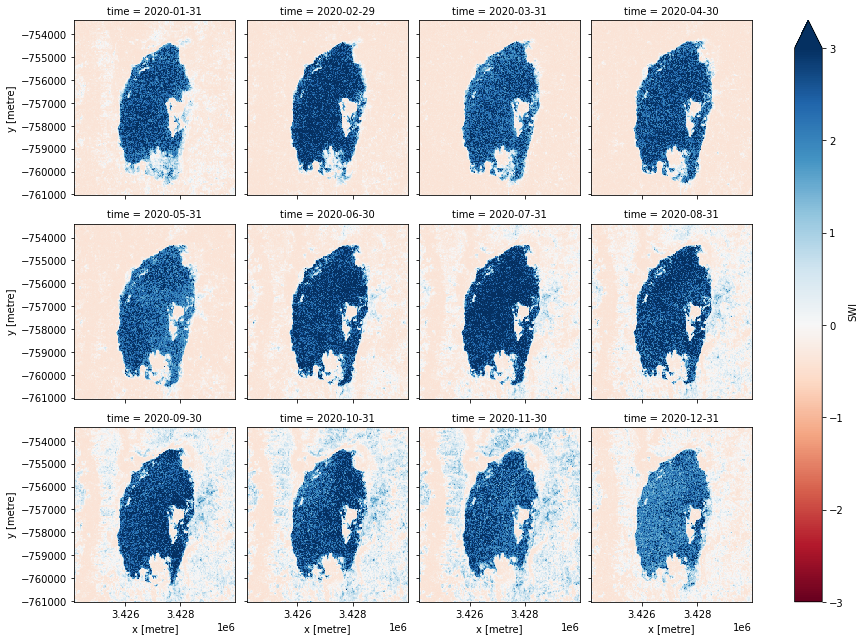

In [15]:
swi.plot.imshow(col="time", col_wrap=4, cmap="RdBu", vmin=-3, vmax=3);

### Facet plot the WOFLs water extent for every month

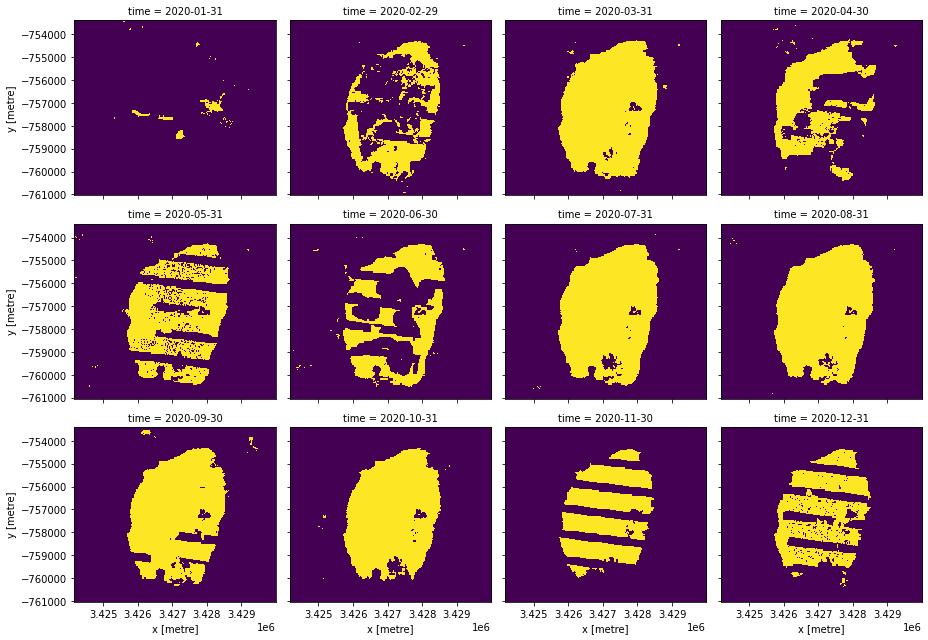

In [16]:
wofs_ls.plot.imshow(col="time", col_wrap=4, add_colorbar=False);

## Calculate the area per pixel
The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [17]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length ** 2 / m_per_km ** 2

## Calculating the water extent per time-step

[Tian et al. 2020]( https://doi.org/10.3390/s20174872) found that the best classification results are obtained using the threshold of 0.2 to distinguish water and non-water from the SWI images. 
If the SWI value of one pixel is more than 0.2, it is regarded as a water body.

Calculates the area of pixels classified as water (if SWI is > 0.2, then water)

In [18]:
water_swi = swi.where(swi > 0.2, np.nan)
area_ds_swi = water_swi.where(np.isnan(water_swi), 1)
ds_valid_water_area_swi = area_ds_swi.sum(dim=["x", "y"]) * area_per_pixel

Calculate the area of pixels classified as water in the WOFLs dataset.

In [19]:
area_ds_wofs_ls = wofs_ls.astype(dtype=np.float64).where(wofs_ls == 1.0, np.nan)
ds_valid_water_area_wofs_ls = area_ds_wofs_ls.sum(dim=["x", "y"]) * area_per_pixel

## Plot a time series of open water area

In [ ]:
plt.figure(figsize=(18, 6))
ds_valid_water_area_swi.plot(marker="o", color="#9467bd")
plt.title(f"Observed Area of Water from {time_range[0]} to {time_range[1]} from SWI")
plt.xlabel("Dates")
plt.ylabel("Waterbody area (km$^2$)")
plt.tight_layout()
plt.savefig(f"results/SWI2_water_extent_{time_range[0]}_to_{time_range[1]}.png")

In [ ]:
plt.figure(figsize=(18, 6))
ds_valid_water_area_wofs_ls.plot(marker="o", color="#9467bd")
plt.title(f"Observed Area of Water from {time_range[0]} to {time_range[1]} from WOFLs")
plt.xlabel("Dates")
plt.ylabel("Waterbody area (km$^2$)")
plt.tight_layout()
plt.savefig(f"results/WOFLs_water_extent_{time_range[0]}_to_{time_range[1]}.png")

## Export time-series as csv

In [ ]:
ds_valid_water_area_swi.to_dataframe().drop('spatial_ref',axis=1).rename({'SWI':'Area of waterbodies from SWI (km2)'},axis=1).to_csv(f'results/SWI2_water_extent_{time_range[0]}_to_{time_range[1]}.csv')

In [ ]:
ds_valid_water_area_wofs_ls.to_dataframe().drop('spatial_ref',axis=1).rename({'water':'Area of waterbodies from WOFLs (km2)'},axis=1).to_csv(f'results/WOFLs_water_extent_{time_range[0]}_to_{time_range[1]}.csv')

## CHIRPS

In [ ]:
# Define the catchment area.
# catchment_vector_file = 'data/Lake_Chad.geojson'
# gdf_catchment = gpd.read_file(catchment_vector_file)
# catchment_bbox=list(gdf_catchment.total_bounds)
# lon_range = (catchment_bbox[0], catchment_bbox[2])
# lat_range = (catchment_bbox[1], catchment_bbox[3])

lat = -5.9460  # -6.0873
lon = 35.5188  # 35.1817

lat_buffer = 4
lon_buffer = 4

# Combine central lat,lon with buffer to get area of interest.
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

display_map(lon_range, lat_range)

In [ ]:
# Create the catchment_query dictionary.

catchment_query = {
    "x": lon_range,
    "y": lat_range,
    "time": time_range,
    "resolution": (-5000, 5000),
    "output_crs": "EPSG:6933",
    "dask_chunks":dask_chunks
}

# Load the Rainfall CHIRPS data.
ds_rf = dc.load(product="rainfall_chirps_monthly", **catchment_query)


print(ds_rf)

In [ ]:
# Create mask.
# mask_rf = xr_rasterize(gdf_catchment, ds_rf)

# Mask data.
# ds_rf = ds_rf.where(mask_rf)

In [ ]:
# Plot the rainfall data.
ds_rf["rainfall"].isel(time=1).plot(cmap="viridis")

In [ ]:
# Plot the monthly precipitation for the catchment area.
var = "rainfall"
rf_plot = ds_rf[var].mean(["y", "x"])

fig, ax1 = plt.subplots(figsize=(18, 6))
# plt.subplot(2,1,1)
rf_plot.plot(
    marker="^",
    markersize=4,
    linewidth=1,
    ax=ax1,
    linestyle="dashed",
    label="Total Precipitation",
)
plt.title("Monthly Rainfall")
plt.ylabel("%s (%s)" % ("Total Precipitation", ds_rf[var].attrs["units"]));

In [ ]:
# Compare the monthly total precipitation for the cathcment area with the open water area from SWI.

fig, ax1 = plt.subplots(figsize=(15, 8))

# plt.subplot(2,1,1)
rf_plot.plot(
    marker="^",
    markersize=4,
    linewidth=1,
    ax=ax1,
    linestyle="dashed",
    label="Precipitation",
)

plt.ylabel("%s (%s)" % ("Total Precipitation", ds_rf[var].attrs["units"]))
plt.title("")

ax2 = ax1.twinx()
ds_valid_water_area_swi.plot(
    color="red", marker="^", markersize=4, linewidth=1, ax=ax2, label="Waterbody Area"
)
plt.title("")
plt.ylabel("Waterbody area (km$^2$)", color="red")
plt.yticks(color="red")

fig.legend(loc="upper left", bbox_to_anchor=(0.05, 0.93))
fig.suptitle(
    f"Evolution of Lake surface area from SWI, compared to catchment rainfall (ERA5) over time from {time_range[0]} to {time_range[1]}"
)
fig.tight_layout()
fig.show()

In [ ]:
# Compare the monthly total precipitation for the cathcment area with the open water area from WOFLs.

fig, ax1 = plt.subplots(figsize=(15, 8))

# plt.subplot(2,1,1)
rf_plot.plot(
    marker="^",
    markersize=4,
    linewidth=1,
    ax=ax1,
    linestyle="dashed",
    label="Precipitation",
)

plt.ylabel("%s (%s)" % ("Total Precipitation", ds_rf[var].attrs["units"]))
plt.title("")

ax2 = ax1.twinx()
ds_valid_water_area_wofs_ls.plot(
    color="red", marker="^", markersize=4, linewidth=1, ax=ax2, label="Waterbody Area"
)
plt.title("")
plt.ylabel("Waterbody area (km$^2$)", color="red")
plt.yticks(color="red")

fig.legend(loc="upper left", bbox_to_anchor=(0.05, 0.93))
fig.suptitle(
    f"Evolution of Lake surface area from WOFLs, compared to catchment rainfall (ERA5) over time from {time_range[0]} to {time_range[1]}"
)
fig.tight_layout()
fig.show()

## Compare water extent between two periods
The following cells determine the maximum extent of water for two different years. 
* `baseline_time` : The baseline year for the analysis
* `analysis_time` : The year to compare to the baseline year

In [ ]:
baseline_time = "2020-01-01"
analysis_time = "2020-12-31"

In [ ]:
baseline_ds_swi, analysis_ds_swi = ds_valid_water_area_swi.sel(
    time=baseline_time, method="nearest"
), ds_valid_water_area_swi.sel(time=analysis_time, method="nearest")

baseline_ds_wofs_ls, analysis_ds_wofs_ls = ds_valid_water_area_wofs_ls.sel(
    time=baseline_time, method="nearest"
), ds_valid_water_area_wofs_ls.sel(time=analysis_time, method="nearest")

A new dataArray is created to store the new date from the `maximum water extent` for the two years

In [ ]:
time_xr_swi = xr.DataArray(
    [baseline_ds_swi.time.values, analysis_ds_swi.time.values], dims=["time"]
)

time_xr_wofs_ls = xr.DataArray(
    [baseline_ds_wofs_ls.time.values, analysis_ds_wofs_ls.time.values], dims=["time"]
)

In [ ]:
print(time_xr_swi.values)
print(time_xr_wofs_ls.values)

## Plotting

Plot water extent of the SWI product for the two chosen periods.

In [ ]:
compare_swi = area_ds_swi.sel(time=time_xr_swi)
compare_swi.plot(
    col="time",
    col_wrap=2,
    robust=True,
    figsize=(10, 5),
    cmap="viridis",
    add_colorbar=False,
);

Plot water extent of the WOFLS product for the two chosen periods.

In [ ]:
compare_wofs_ls = area_ds_wofs_ls.sel(time=time_xr_wofs_ls)
compare_wofs_ls.plot(
    col="time", col_wrap=2, figsize=(10, 5), cmap="viridis", add_colorbar=False
);

## Save the water extents as geotiffs

Both the 'analysis time' and the 'baseline time' water extents will be saved as cloud-opimtised geotiffs in the `results/` folder.

In [ ]:
baseline_time_swi = np.datetime_as_string(time_xr_swi.values[0], unit="D")
analysis_time_swi = np.datetime_as_string(time_xr_swi.values[1], unit="D")

write_cog(
    area_ds_swi.sel(time=baseline_time_swi),
    fname="results/SWI2_water_extent_" + baseline_time_swi + ".tif",
    overwrite=True,
)

write_cog(
    area_ds_swi.sel(time=analysis_time_swi),
    fname="results/SWI2_water_extent_" + analysis_time_swi + ".tif",
    overwrite=True,
)

In [ ]:
baseline_time_wofs_ls = np.datetime_as_string(baseline_ds_wofs_ls.time.values, unit='D')
analysis_time_wofs_ls = np.datetime_as_string(analysis_ds_wofs_ls.time.values, unit='D')

write_cog(area_ds_wofs_ls.sel(time=baseline_time_wofs_ls),
          fname='results/WOFLs_water_extent_'+baseline_time_wofs_ls+'.tif',
          overwrite=True)
write_cog(area_ds_wofs_ls.sel(time=analysis_time_wofs_ls),
          fname='results/WOFLs_water_extent_'+analysis_time_wofs_ls+'.tif',
          overwrite=True)

## Calculating the change for the two nominated periods
The cells below calculate the amount of water gain, loss and stable for the two periods

In [ ]:
# Extract the two periods(Baseline and analysis) dataset from
ds_selected_swi = area_ds_swi.where(area_ds_swi == 1, 0).sel(time=time_xr_swi)


analyse_total_value_swi = ds_selected_swi[1]
change_swi = analyse_total_value_swi - ds_selected_swi[0]

water_appeared_swi = change_swi.where(change_swi == 1)
permanent_water_swi = change_swi.where((change_swi == 0) & (analyse_total_value_swi == 1))
permanent_land_swi = change_swi.where((change_swi == 0) & (analyse_total_value_swi == 0))
water_disappeared_swi = change_swi.where(change_swi == -1)

In [ ]:
# Extract the two periods(Baseline and analysis) dataset from
ds_selected_wofs_ls = area_ds_wofs_ls.where(area_ds_wofs_ls == 1, 0).sel(time=time_xr_wofs_ls)

analyse_total_value_wofs_ls = ds_selected_wofs_ls[1]
change_wofs_ls = analyse_total_value_wofs_ls - ds_selected_wofs_ls[0]

water_appeared_wofs_ls = change_wofs_ls.where(change_wofs_ls == 1)
permanent_water_wofs_ls = change_wofs_ls.where((change_wofs_ls == 0) & (analyse_total_value_wofs_ls == 1))
permanent_land_wofs_ls = change_wofs_ls.where((change_wofs_ls == 0) & (analyse_total_value_wofs_ls == 0))
water_disappeared_wofs_ls = change_wofs_ls.where(change_wofs_ls == -1)

The cells below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [ ]:
total_area_swi = analyse_total_value_swi.count().values * area_per_pixel
water_apperaed_area_swi = water_appeared_swi.count().values * area_per_pixel
permanent_water_area_swi = permanent_water_swi.count().values * area_per_pixel
water_disappeared_area_swi = water_disappeared_swi.count().values * area_per_pixel

In [ ]:
total_area_wofs_ls = analyse_total_value_wofs_ls.count().values * area_per_pixel
water_apperaed_area_wofs_ls = water_appeared_wofs_ls.count().values * area_per_pixel
permanent_water_area_wofs_ls = permanent_water_wofs_ls.count().values * area_per_pixel
water_disappeared_area_wofs_ls = water_disappeared_wofs_ls.count().values * area_per_pixel

## Plotting
The water variables are plotted to visualised the result

In [ ]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ds_selected_swi[1].plot.imshow(
    cmap="Pastel1",
    add_colorbar=False,
    add_labels=False,
    ax=ax
)
water_appeared_swi.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared_swi.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water_swi.plot.imshow(
    cmap=ListedColormap([stable_color]),                           
    add_colorbar=False,
    add_labels=False,
    ax=ax
)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area_swi, 2)} km2",
        f"Water to No Water {round(water_disappeared_area_swi, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area_swi, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent using SWI: " + baseline_time + " to " + analysis_time);

In [ ]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ds_selected_wofs_ls[1].plot.imshow(
    cmap="Pastel1",
    add_colorbar=False,
    add_labels=False,
    ax=ax
)
water_appeared_wofs_ls.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared_wofs_ls.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water_wofs_ls.plot.imshow(
    cmap=ListedColormap([stable_color]),                           
    add_colorbar=False,
    add_labels=False,
    ax=ax
)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area_wofs_ls, 2)} km2",
        f"Water to No Water {round(water_disappeared_area_wofs_ls, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area_wofs_ls, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent using WOfS: " + baseline_time + " to " + analysis_time);

## Next steps


Return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `start_year`, `end_year`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

Change the year also in "Compare Two Time Periods - a Baseline and an Analysis" section, (e.g. `base_year`, `analyse_year`) and re-run the analysis.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')